框架

    工具准备
    导入数据
    数据探索分析
        - 分析热销商品
        - 分析热销品类
        - 分析品类结构
        - 分析各品类下的商品
    数据预处理
    构建模型
        - 挖掘频繁项集
        - 挖掘关联规则

### 一、工具准备

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # 取消科学计数法

plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题

#pip install mlxtend
#from mlxtend.preprocessing import TransactionEncoder     #编码
from mlxtend.frequent_patterns import apriori            #挖掘频繁项集
from mlxtend.frequent_patterns import association_rules  #挖掘关联规则

# pip install wordcloud
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter

import os
import openpyxl #结果保存到同一个工作簿的不同工作表

#pip install pyecharts

In [24]:
# print(plt.style.available) # 获取所有的自带样式

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


### 二、导入数据

In [7]:
goodsorder=pd.read_csv('./GoodsOrder.csv',encoding='gbk')
goodsorder.head()
goodsorder.info()

# 在一个周期内的商品零售数据，注意，这里没有价格、成本。关联规则挖掘与金额和数量无关，与购买频次有关。
# id是订单编号，Goods是购买商品名称

,id,Goods
0,1,柑橘类水果
1,1,人造黄油
2,1,即食汤
3,1,半成品面包
4,2,咖啡


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43367 entries, 0 to 43366
Data columns (total 2 columns):
id       43367 non-null int64
Goods    43367 non-null object
dtypes: int64(1), object(1)
memory usage: 677.7+ KB


In [8]:
goodstypes=pd.read_csv('./GoodsTypes.csv',encoding='gbk')
goodstypes.head()
goodstypes.info()

# Goods是商品名称，Types是商品类别

,Goods,Types
0,白饭,熟食
1,白酒,酒精饮料
2,白兰地,酒精饮料
3,白面包,西点
4,半成品面包,西点


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
Goods    169 non-null object
Types    169 non-null object
dtypes: object(2)
memory usage: 2.8+ KB


In [9]:
print('各商品类别下的商品数量：')
goodstypes.Types.value_counts()

各商品类别下的商品数量：


百货       43
米粮调料     32
西点       21
肉类       16
果蔬       14
酒精饮料     11
非酒精饮料    11
熟食        9
零食        8
食品类       4
Name: Types, dtype: int64

### 三、数据探索分析

#### （一）分析热销商品

从商品名称维度统计顾客的购买频次

In [10]:
print('总购买频次：')
len(goodsorder.id.unique())
print('每件商品的购买频次')
goodsorder.Goods.value_counts()

总购买频次：


9835

每件商品的购买频次


全脂牛奶    2513
其他蔬菜    1903
面包卷     1809
苏打      1715
酸奶      1372
        ... 
包装袋        4
厨房用具       4
防腐用品       2
唱片         1
婴儿食品       1
Name: Goods, Length: 169, dtype: int64

In [11]:
gvc=goodsorder.Goods.value_counts() #每个商品的购买频次
ivc=len(goodsorder.id.unique()) #订单数量，即总购买频次
gpd=pd.concat([gvc,gvc/ivc],axis=1)
gpd.columns=['购买频次','购买概率']
gpd.head(10)
gpd.to_csv('./商品购买频次与概率.csv',index=True,header=True,encoding='gbk')

,购买频次,购买概率
全脂牛奶,2513,0.26
其他蔬菜,1903,0.19
面包卷,1809,0.18
苏打,1715,0.17
酸奶,1372,0.14
瓶装水,1087,0.11
根茎类蔬菜,1072,0.11
热带水果,1032,0.10
购物袋,969,0.10
香肠,924,0.09


<Figure size 720x720 with 0 Axes>

Text(0.5, 0, '商品类别')

Text(0, 0.5, '销售频次')

Text(0.5, 1.0, '商品销售频次TOP10')

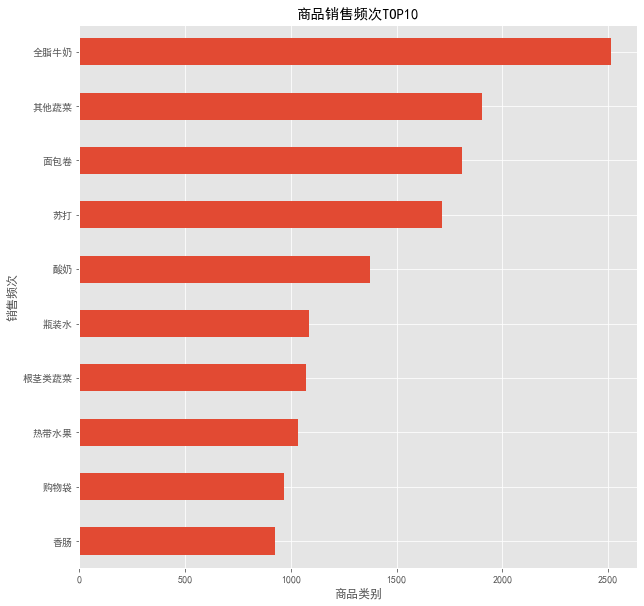

In [12]:
plt.figure(figsize=(10,10))
goodsorder.Goods.value_counts().head(10).sort_values(ascending=True).plot(kind='barh')
plt.xlabel('商品类别')
plt.ylabel('销售频次')
plt.title('商品销售频次TOP10')
plt.savefig('./商品销售频次TOP10.png')
plt.show()

<Figure size 1440x720 with 0 Axes>

(-0.5, 1599.5, 1199.5, -0.5)

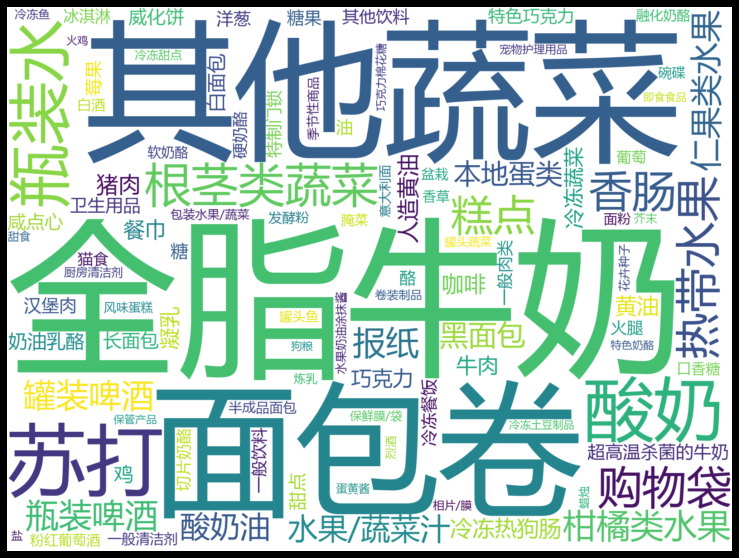

In [13]:
font=r"C:\Windows\Fonts\msyh.ttc"

my_wordcloud = WordCloud(font_path=font, max_words = 100,width=1600, height=1200, mode='RGBA', background_color='white') 
my_wordcloud.generate_from_frequencies(Counter(goodsorder.Goods.values))
my_wordcloud.to_file('热销商品100词云图.png')
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(my_wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

<Figure size 1440x720 with 0 Axes>

(-0.5, 1599.5, 1199.5, -0.5)

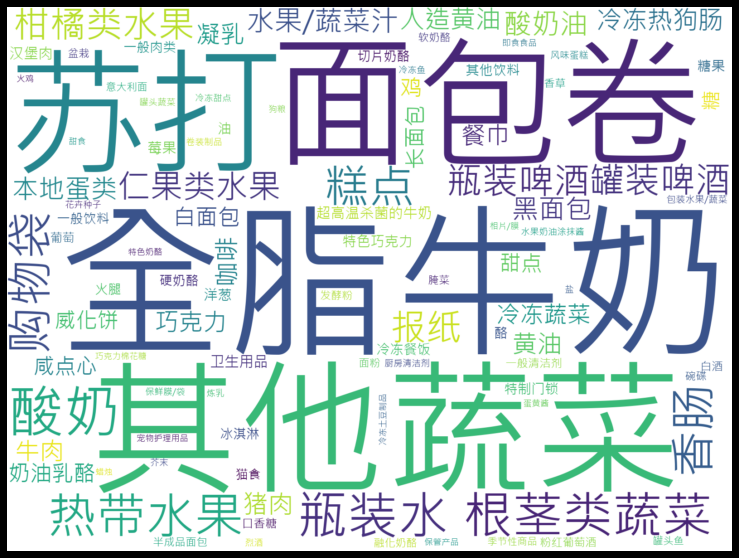

In [8]:
font_2=r"./msjh.ttf"

my_wordcloud = WordCloud(font_path=font_2, max_words = 100,width=1600, height=1200, mode='RGBA', background_color='white') 
my_wordcloud.generate_from_frequencies(Counter(goodsorder.Goods.values))
my_wordcloud.to_file('热销商品100词云图.png')
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(my_wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [5]:
#方法二
#from pyecharts.charts import WordCloud

ModuleNotFoundError: No module named 'pyecharts'

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, '商品类别')

Text(0, 0.5, '销售频次')

Text(0.5, 1.0, '商品销售频次Bottom10')

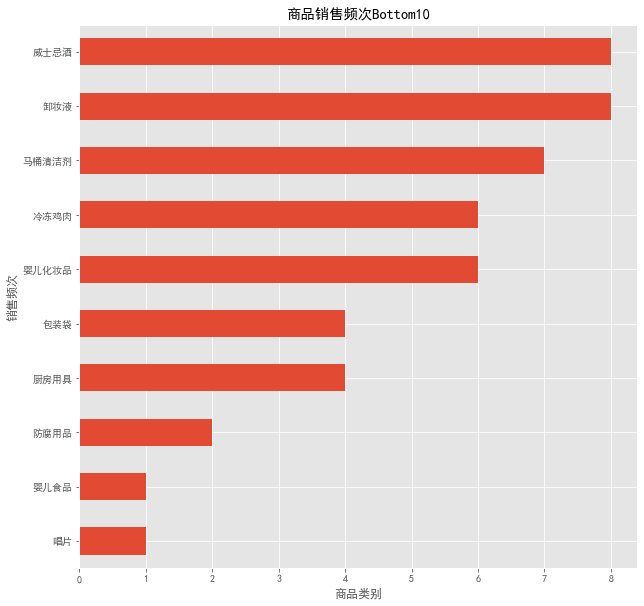

In [40]:
plt.figure(figsize=(10,10))
goodsorder.Goods.value_counts().tail(10).sort_values(ascending=True).plot(kind='barh')
plt.xlabel('商品类别')
plt.ylabel('销售频次')
plt.title('商品销售频次Bottom10')
plt.show()

#### （二）分析热销品类

从商品类别维度统计顾客的购买频次

In [14]:
data=pd.merge(goodsorder,goodstypes)
data.head()

,id,Goods,Types
0,1,柑橘类水果,果蔬
1,12,柑橘类水果,果蔬
2,40,柑橘类水果,果蔬
3,73,柑橘类水果,果蔬
4,77,柑橘类水果,果蔬


In [15]:
unique_data=data[['id','Types']]
unique_data.shape
unique_data=unique_data.drop_duplicates() #为计算每种商品类别的购买频次，需要去重。即如果每次购买商品包含两种水果，只能算一次。
unique_data.shape

(43285, 2)

(30535, 2)

In [16]:

tvc=unique_data.Types.value_counts() #从商品类别维度统计顾客购买的频次
c=len(goodsorder.id.unique()) #总购买频次
tpd=pd.concat([tvc,tvc/c],axis=1)
tpd.columns=['购买频次','购买概率']

print('顾客购买商品类别的概率：')
tpd

#解读：也就是说顾客每次购买有54%的概率会买非酒精饮料，有48%的概率会买西点，有44%的概率会买果蔬。而只有5%的概率会买熟食。

顾客购买商品类别的概率：


,购买频次,购买概率
非酒精饮料,5350,0.54
西点,4730,0.48
果蔬,4282,0.44
百货,3728,0.38
肉类,3481,0.35
米粮调料,3396,0.35
酒精饮料,1991,0.20
食品类,1771,0.18
零食,1304,0.13
熟食,502,0.05


#### （三）分析品类结构

In [50]:
tvc/tvc.sum()

非酒精饮料   0.18
西点      0.15
果蔬      0.14
百货      0.12
肉类      0.11
米粮调料    0.11
酒精饮料    0.07
食品类     0.06
零食      0.04
熟食      0.02
Name: Types, dtype: float64

<Figure size 576x432 with 0 Axes>

([<matplotlib.patches.Wedge at 0x18b16e4f948>,
 [Text(0.937527005675923, 0.5753634621944099, '非酒精饮料'),
  Text(-0.018389811785838577, 1.0998462687223527, '西点'),
  Text(-0.890849045070722, 0.6452813176410602, '果蔬'),
  Text(-1.0786743469886448, -0.21554965355718142, '百货'),
  Text(-0.6497185207104067, -0.8876180731856923, '肉类'),
  Text(0.08315962801512852, -1.096852075837205, '米粮调料'),
  Text(0.6479820936410084, -0.8888864979965753, '酒精饮料'),
  Text(0.9355681189462032, -0.578543252325583, '食品类'),
  Text(1.0691328455129234, -0.2587565625166627, '零食'),
  Text(1.0985331770176636, -0.05678784193362667, '熟食')],
 [Text(0.5113783667323216, 0.31383461574240534, '17.52%'),
  Text(-0.010030806428639223, 0.5999161465758286, '15.49%'),
  Text(-0.48591766094766653, 0.3519716278042146, '14.02%'),
  Text(-0.5883678256301698, -0.11757253830391712, '12.21%'),
  Text(-0.35439192038749456, -0.4841553126467412, '11.40%'),
  Text(0.04535979709916101, -0.5982829504566571, '11.12%'),
  Text(0.35344477834964094, -0

Text(0.5, 1.0, '每类商品销售频次占比')

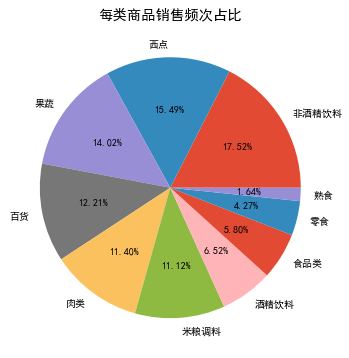

In [58]:
labels=tvc.index

plt.figure(figsize=(8,6))
plt.pie(tvc/tvc.sum(),labels=labels,autopct='%1.2f%%')
plt.title('每类商品销售频次占比')
plt.savefig('./每类商品销售频次占比.png')
plt.show()

#### （四）分析各品类下的商品

- 非酒精饮料

In [17]:
cate_data=data[data['Types']=='非酒精饮料'][['id','Goods']]

cate_gvc=cate_data.Goods.value_counts() #从商品维度统计顾客购买的频次
c=len(cate_data.id.unique()) #非酒精饮料的总购买频次
print('非酒精饮料的总购买频次：%d'% c)

cate_gvc_pd=pd.concat([cate_gvc,cate_gvc/c],axis=1)
cate_gvc_pd.columns=['购买频次','购买概率']

print('顾客购买商品类别的概率：')
cate_gvc_pd

#解读：也就是说顾客每次购买非酒精饮料时，有47%的概率会买全脂牛奶

非酒精饮料的总购买频次：5350
顾客购买商品类别的概率：


,购买频次,购买概率
全脂牛奶,2513,0.47
苏打,1715,0.32
瓶装水,1087,0.20
水果/蔬菜汁,711,0.13
咖啡,571,0.11
超高温杀菌的牛奶,329,0.06
其他饮料,279,0.05
一般饮料,256,0.05
速溶咖啡,73,0.01
茶,38,0.01


- 一次性输出

In [70]:
all_cates=goodstypes.Types.unique()

wb_out='./各品类各商品的购买频次.xlsx'
writer=pd.ExcelWriter(wb_out,engine='openpyxl')

for cate in all_cates:

    cate_data=data[data['Types']==cate][['id','Goods']]

    cate_gvc=cate_data.Goods.value_counts() #从商品维度统计顾客购买的频次
    c=len(cate_data.id.unique()) #cate的总购买频次
    print('%s的总购买频次：%d'% (cate,c))

    cate_gvc_pd=pd.concat([cate_gvc,cate_gvc/c],axis=1)
    cate_gvc_pd.columns=['购买频次','购买概率']

    print('顾客购买商品类别的概率：')
    cate_gvc_pd
    
    print('-------------------------------------------------')
    
    cate_gvc_pd.to_excel(writer,sheet_name=cate,index=True)
writer.save()

熟食的总购买频次：502
顾客购买商品类别的概率：


,购买频次,购买概率
意大利面,148,0.29
即食食品,79,0.16
白饭,75,0.15
汤类,67,0.13
成品,64,0.13
糖水,32,0.06
小吃类食品,30,0.06
马铃薯产品,28,0.06
即食汤,18,0.04


-------------------------------------------------
酒精饮料的总购买频次：1991
顾客购买商品类别的概率：


,购买频次,购买概率
瓶装啤酒,792,0.40
罐装啤酒,764,0.38
粉红葡萄酒,189,0.09
白酒,187,0.09
烈酒,109,0.05
开胃酒,78,0.04
起泡酒,55,0.03
朗姆酒,44,0.02
白兰地,41,0.02
普罗赛克葡萄酒,20,0.01


-------------------------------------------------
西点的总购买频次：4730
顾客购买商品类别的概率：


,购买频次,购买概率
面包卷,1809,0.38
糕点,875,0.18
黑面包,638,0.13
白面包,414,0.09
奶油乳酪,390,0.08
威化饼,378,0.08
咸点心,372,0.08
长面包,368,0.08
甜点,365,0.08
酪,275,0.06


-------------------------------------------------
百货的总购买频次：3728
顾客购买商品类别的概率：


,购买频次,购买概率
购物袋,969,0.26
报纸,785,0.21
餐巾,515,0.14
卫生用品,324,0.09
特制门锁,269,0.07
猫食,229,0.06
一般清洁剂,189,0.05
碗碟,173,0.05
盆栽,170,0.05
季节性商品,140,0.04


-------------------------------------------------
果蔬的总购买频次：4282
顾客购买商品类别的概率：


,购买频次,购买概率
其他蔬菜,1903,0.44
根茎类蔬菜,1072,0.25
热带水果,1032,0.24
柑橘类水果,814,0.19
仁果类水果,744,0.17
冷冻蔬菜,473,0.11
莓果,327,0.08
洋葱,305,0.07
葡萄,220,0.05
包装水果/蔬菜,128,0.03


-------------------------------------------------
零食的总购买频次：1304
顾客购买商品类别的概率：


,购买频次,购买概率
巧克力,488,0.37
糖果,294,0.23
冰淇淋,246,0.19
口香糖,207,0.16
巧克力棉花糖,89,0.07
爆米花,71,0.05
坚果/李子,33,0.03
坚果小吃,31,0.02


-------------------------------------------------
肉类的总购买频次：3481
顾客购买商品类别的概率：


,购买频次,购买概率
香肠,924,0.27
本地蛋类,624,0.18
冷冻热狗肠,580,0.17
猪肉,567,0.16
牛肉,516,0.15
鸡,422,0.12
汉堡肉,327,0.09
火腿,256,0.07
一般肉类,254,0.07
冷冻鱼,115,0.03


-------------------------------------------------
米粮调料的总购买频次：3396
顾客购买商品类别的概率：


,购买频次,购买概率
酸奶油,705,0.21
人造黄油,576,0.17
黄油,545,0.16
凝乳,524,0.15
糖,333,0.10
冷冻餐饭,279,0.08
油,276,0.08
发酵粉,174,0.05
面粉,171,0.05
融化奶酪,163,0.05


-------------------------------------------------
非酒精饮料的总购买频次：5350
顾客购买商品类别的概率：


,购买频次,购买概率
全脂牛奶,2513,0.47
苏打,1715,0.32
瓶装水,1087,0.20
水果/蔬菜汁,711,0.13
咖啡,571,0.11
超高温杀菌的牛奶,329,0.06
其他饮料,279,0.05
一般饮料,256,0.05
速溶咖啡,73,0.01
茶,38,0.01


-------------------------------------------------
食品类的总购买频次：1771
顾客购买商品类别的概率：


,购买频次,购买概率
酸奶,1372,0.77
特色巧克力,299,0.17
腌菜,176,0.10
小食,23,0.01


-------------------------------------------------


### 四、数据预处理

In [71]:
goodsorder.head()

,id,Goods
0,1,柑橘类水果
1,1,人造黄油
2,1,即食汤
3,1,半成品面包
4,2,咖啡


In [19]:
modeldata=pd.crosstab(index=goodsorder.id,columns=goodsorder.Goods)
modeldata.shape
modeldata.head()

(9835, 169)

Goods,一般清洁剂,一般肉类,一般饮料,人造黄油,仁果类水果,保管产品,保鲜膜/袋,全脂牛奶,其他蔬菜,其他饮料,...,餐巾,香肠,香草,香辛料,马桶清洁剂,马铃薯产品,鱼,鸡,黄油,黑面包
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
modeldata.max().max()

1

### 五、构建模型

#### （一）挖掘频繁项集

In [88]:
support_20perc=apriori(modeldata,min_support=0.2,use_colnames=True)
support_20perc

,support,itemsets
0,0.26,(全脂牛奶)


In [22]:
support_10perc=apriori(modeldata,min_support=0.1,use_colnames=True)
support_10perc

,support,itemsets
0,0.26,(全脂牛奶)
1,0.19,(其他蔬菜)
2,0.11,(根茎类蔬菜)
3,0.10,(热带水果)
4,0.11,(瓶装水)
5,0.17,(苏打)
6,0.14,(酸奶)
7,0.18,(面包卷)


In [20]:
support_5perc=apriori(modeldata,min_support=0.05,use_colnames=True)
support_5perc

,support,itemsets
0,0.06,(人造黄油)
1,0.08,(仁果类水果)
2,0.26,(全脂牛奶)
3,0.19,(其他蔬菜)
4,0.06,(冷冻热狗肠)
5,0.05,(凝乳)
6,0.06,(咖啡)
7,0.08,(报纸)
8,0.06,(本地蛋类)
9,0.08,(柑橘类水果)


In [92]:
support_3perc=apriori(modeldata,min_support=0.03,use_colnames=True)
support_3perc

,support,itemsets
0,0.06,(人造黄油)
1,0.08,(仁果类水果)
2,0.26,(全脂牛奶)
3,0.19,(其他蔬菜)
4,0.06,(冷冻热狗肠)
...,...,...
58,0.04,"(其他蔬菜, 酸奶)"
59,0.04,"(面包卷, 其他蔬菜)"
60,0.04,"(苏打, 面包卷)"
61,0.03,"(面包卷, 酸奶)"


In [91]:
support_1perc=apriori(modeldata,min_support=0.01,use_colnames=True)
support_1perc

support_1perc.to_csv('./支持度1%以上的频繁项集.csv',index=True,header=True,encoding='gbk')

,support,itemsets
0,0.02,(一般清洁剂)
1,0.03,(一般肉类)
2,0.03,(一般饮料)
3,0.06,(人造黄油)
4,0.08,(仁果类水果)
...,...,...
328,0.01,"(根茎类蔬菜, 其他蔬菜, 酸奶)"
329,0.01,"(面包卷, 其他蔬菜, 根茎类蔬菜)"
330,0.01,"(热带水果, 其他蔬菜, 酸奶)"
331,0.01,"(酸奶油, 其他蔬菜, 酸奶)"


#### （四）挖掘关联规则

#### （1）支持度大于10%的频繁项集

In [23]:
print('最小置信度为0.5时：')
association_rules(support_10perc,metric='confidence',min_threshold=0.5)
print('--------------------')

print('最小置信度为0.4时：')
association_rules(support_10perc,metric='confidence',min_threshold=0.4)
print('--------------------')

print('最小置信度为0.3时：')
association_rules(support_10perc,metric='confidence',min_threshold=0.3)
print('--------------------')

print('最小置信度为0.2时：')
association_rules(support_10perc,metric='confidence',min_threshold=0.2)
print('--------------------')

print('最小置信度为0.1时：')
association_rules(support_10perc,metric='confidence',min_threshold=0.1)
print('--------------------')

最小置信度为0.5时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


--------------------
最小置信度为0.4时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


--------------------
最小置信度为0.3时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


--------------------
最小置信度为0.2时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


--------------------
最小置信度为0.1时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


--------------------


In [102]:
print('提升度大于1时：')
association_rules(support_10perc,metric='lift',min_threshold=1)

提升度大于1时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


#### （2）支持度大于5%的频繁项集

In [106]:
print('最小置信度为0.5时：')
association_rules(support_5perc,metric='confidence',min_threshold=0.5)
print('--------------------')

print('最小置信度为0.4时：')
association_rules(support_5perc,metric='confidence',min_threshold=0.4)
print('--------------------')

print('最小置信度为0.3时：')
association_rules(support_5perc,metric='confidence',min_threshold=0.3)

最小置信度为0.5时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


--------------------
最小置信度为0.4时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(酸奶),(全脂牛奶),0.14,0.26,0.06,0.40,1.57,0.02,1.24


--------------------
最小置信度为0.3时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(其他蔬菜),(全脂牛奶),0.19,0.26,0.07,0.39,1.51,0.03,1.21
1,(酸奶),(全脂牛奶),0.14,0.26,0.06,0.40,1.57,0.02,1.24
2,(面包卷),(全脂牛奶),0.18,0.26,0.06,0.31,1.21,0.01,1.08


#### （3）支持度大于3%的频繁项集

In [110]:
print('最小置信度为0.5时：')
association_rules(support_3perc,metric='confidence',min_threshold=0.5)
print('--------------------')

print('最小置信度为0.4时：')
association_rules(support_3perc,metric='confidence',min_threshold=0.4)
print('--------------------')
ass=association_rules(support_3perc,metric='confidence',min_threshold=0.4)
ass.to_csv('./关联商品.csv',encoding='gbk')

print('最小置信度为0.3时：')
association_rules(support_3perc,metric='confidence',min_threshold=0.3)

最小置信度为0.5时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


--------------------
最小置信度为0.4时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(根茎类蔬菜),(全脂牛奶),0.11,0.26,0.05,0.45,1.76,0.02,1.35
1,(热带水果),(全脂牛奶),0.10,0.26,0.04,0.40,1.58,0.02,1.25
2,(酸奶),(全脂牛奶),0.14,0.26,0.06,0.40,1.57,0.02,1.24
3,(酸奶油),(全脂牛奶),0.07,0.26,0.03,0.45,1.76,0.01,1.35
4,(根茎类蔬菜),(其他蔬菜),0.11,0.19,0.05,0.43,2.25,0.03,1.43


--------------------
最小置信度为0.3时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(仁果类水果),(全脂牛奶),0.08,0.26,0.03,0.40,1.56,0.01,1.24
1,(其他蔬菜),(全脂牛奶),0.19,0.26,0.07,0.39,1.51,0.03,1.21
2,(柑橘类水果),(全脂牛奶),0.08,0.26,0.03,0.37,1.44,0.01,1.18
3,(根茎类蔬菜),(全脂牛奶),0.11,0.26,0.05,0.45,1.76,0.02,1.35
4,(热带水果),(全脂牛奶),0.10,0.26,0.04,0.40,1.58,0.02,1.25
5,(瓶装水),(全脂牛奶),0.11,0.26,0.03,0.31,1.22,0.01,1.08
6,(糕点),(全脂牛奶),0.09,0.26,0.03,0.37,1.46,0.01,1.19
7,(酸奶),(全脂牛奶),0.14,0.26,0.06,0.40,1.57,0.02,1.24
8,(酸奶油),(全脂牛奶),0.07,0.26,0.03,0.45,1.76,0.01,1.35
9,(面包卷),(全脂牛奶),0.18,0.26,0.06,0.31,1.21,0.01,1.08


#### （4）支持度大于1%的频繁项集

In [109]:
print('最小置信度为0.5时：')
association_rules(support_1perc,metric='confidence',min_threshold=0.5)
print('--------------------')

print('最小置信度为0.4时：')
association_rules(support_1perc,metric='confidence',min_threshold=0.4)
print('--------------------')

print('最小置信度为0.3时：')
association_rules(support_1perc,metric='confidence',min_threshold=0.3)

最小置信度为0.5时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(仁果类水果, 其他蔬菜)",(全脂牛奶),0.03,0.26,0.01,0.52,2.03,0.01,1.54
1,"(其他蔬菜, 本地蛋类)",(全脂牛奶),0.02,0.26,0.01,0.55,2.16,0.01,1.66
2,"(其他蔬菜, 酸奶)",(全脂牛奶),0.04,0.26,0.02,0.51,2.01,0.01,1.53
3,"(其他蔬菜, 酸奶油)",(全脂牛奶),0.03,0.26,0.01,0.51,1.98,0.01,1.51
4,"(黄油, 其他蔬菜)",(全脂牛奶),0.02,0.26,0.01,0.57,2.24,0.01,1.75
5,"(凝乳, 酸奶)",(全脂牛奶),0.02,0.26,0.01,0.58,2.28,0.01,1.78
6,"(热带水果, 根茎类蔬菜)",(全脂牛奶),0.02,0.26,0.01,0.57,2.23,0.01,1.73
7,"(酸奶, 根茎类蔬菜)",(全脂牛奶),0.03,0.26,0.01,0.56,2.20,0.01,1.70
8,"(面包卷, 根茎类蔬菜)",(全脂牛奶),0.02,0.26,0.01,0.52,2.05,0.01,1.56
9,"(热带水果, 酸奶)",(全脂牛奶),0.03,0.26,0.02,0.52,2.02,0.01,1.54


--------------------
最小置信度为0.4时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(人造黄油),(全脂牛奶),0.06,0.26,0.02,0.41,1.62,0.01,1.27
1,(冷冻蔬菜),(全脂牛奶),0.05,0.26,0.02,0.42,1.66,0.01,1.29
2,(凝乳),(全脂牛奶),0.05,0.26,0.03,0.49,1.92,0.01,1.46
3,(切片奶酪),(全脂牛奶),0.02,0.26,0.01,0.44,1.72,0.00,1.33
4,(奶油乳酪),(全脂牛奶),0.04,0.26,0.02,0.42,1.63,0.01,1.27
...,...,...,...,...,...,...,...,...,...
57,"(热带水果, 根茎类蔬菜)",(其他蔬菜),0.02,0.19,0.01,0.58,3.02,0.01,1.94
58,"(酸奶, 根茎类蔬菜)",(其他蔬菜),0.03,0.19,0.01,0.50,2.58,0.01,1.61
59,"(面包卷, 根茎类蔬菜)",(其他蔬菜),0.02,0.19,0.01,0.50,2.59,0.01,1.62
60,"(热带水果, 酸奶)",(其他蔬菜),0.03,0.19,0.01,0.42,2.17,0.01,1.39


--------------------
最小置信度为0.3时：


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(人造黄油),(全脂牛奶),0.06,0.26,0.02,0.41,1.62,0.01,1.27
1,(人造黄油),(其他蔬菜),0.06,0.19,0.02,0.34,1.74,0.01,1.22
2,(仁果类水果),(全脂牛奶),0.08,0.26,0.03,0.40,1.56,0.01,1.24
3,(仁果类水果),(其他蔬菜),0.08,0.19,0.03,0.35,1.79,0.01,1.23
4,(其他蔬菜),(全脂牛奶),0.19,0.26,0.07,0.39,1.51,0.03,1.21
...,...,...,...,...,...,...,...,...,...
120,"(热带水果, 其他蔬菜)",(酸奶),0.04,0.14,0.01,0.34,2.46,0.01,1.31
121,"(热带水果, 酸奶)",(其他蔬菜),0.03,0.19,0.01,0.42,2.17,0.01,1.39
122,"(其他蔬菜, 酸奶油)",(酸奶),0.03,0.14,0.01,0.35,2.52,0.01,1.33
123,"(酸奶油, 酸奶)",(其他蔬菜),0.02,0.19,0.01,0.49,2.53,0.01,1.58
